In [2]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

FileNotFoundError: [Errno 2] No such file or directory: '/content/archive.zip'

In [3]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [4]:
print(df.shape)

(5110, 12)


In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [6]:
print(df.isnull().sum())


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [7]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)


/tmp/ipython-input-749786099.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [8]:
print(df['bmi'].isnull().sum())


0


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    df[col] = le.fit_transform(df[col])


In [10]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)


In [11]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
X = df.drop(['id', 'stroke'], axis=1)  # Features (drop id and target)
y = df['stroke']                       # Target variable


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Confusion Matrix:
 [[968   4]
 [ 50   0]]
ROC AUC Score: 0.7641152263374485


In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [18]:
# If you don't have imblearn installed, run this once in your environment:
# !pip install imblearn

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train the Random Forest on balanced data
rf_bal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bal.fit(X_train_bal, y_train_bal)

# Predict on the original test set
y_pred_bal = rf_bal.predict(X_test)
y_proba_bal = rf_bal.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_bal))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       972
           1       0.08      0.10      0.09        50

    accuracy                           0.90      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.91      0.90      0.90      1022

Confusion Matrix:
 [[914  58]
 [ 45   5]]
ROC AUC Score: 0.7626543209876543


In [19]:
import numpy as np
y_proba_bal = rf_bal.predict_proba(X_test)[:, 1]

# Set custom threshold
threshold = 0.3
y_pred_thresh = (y_proba_bal >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.13      0.34      0.19        50

    accuracy                           0.85      1022
   macro avg       0.55      0.61      0.55      1022
weighted avg       0.92      0.85      0.88      1022

Confusion Matrix:
 [[856 116]
 [ 33  17]]


In [20]:
# If you don’t have xgboost installed, run this once:
# !pip install xgboost

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train on the balanced training set
xgb_clf.fit(X_train_bal, y_train_bal)

# Predict probabilities and classes on test set
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.12      0.14      0.13        50

    accuracy                           0.91      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.91      0.91      0.91      1022

Confusion Matrix:
 [[921  51]
 [ 43   7]]
ROC AUC Score: 0.7268312757201647


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:51:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_bal, y_train_bal)

print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:52:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


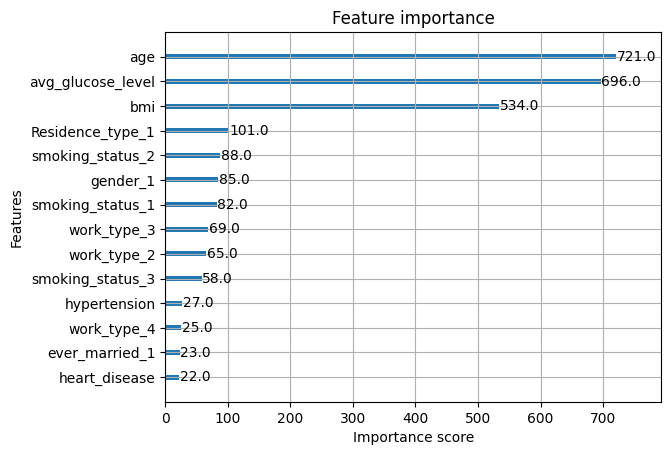

In [22]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_clf)
plt.show()


In [23]:
def predict_stroke(input_data, model):
    """
    input_data: dict with keys as feature names, values as user inputs
    model: your trained ML model (e.g., best_model)
    """

    import pandas as pd

    # Convert input dict to DataFrame
    df_input = pd.DataFrame([input_data])

    # Make sure to apply same preprocessing as training data:
    # - Encode categorical variables exactly the same way
    # - Fill missing bmi if needed
    # - Align columns order with training features

    # For example, encode gender if needed (assuming label encoding):
    # df_input['gender'] = label_encoder_gender.transform(df_input['gender'])

    # For now, assuming input_data already encoded or you add encoding here

    # Predict probability and class
    prob = model.predict_proba(df_input)[:, 1][0]
    pred_class = model.predict(df_input)[0]

    return pred_class, prob


In [24]:
def predict_stroke_interactive(model, training_columns):
    """
    model: your trained ML model (e.g., best_model)
    training_columns: list of column names from the training data
    """
    print("Enter patient details for stroke prediction:")

    # Collect inputs (make sure types match training data)
    age = float(input("Age: "))
    hypertension = int(input("Hypertension (0 = No, 1 = Yes): "))
    heart_disease = int(input("Heart Disease (0 = No, 1 = Yes): "))
    avg_glucose_level = float(input("Average Glucose Level: "))
    bmi = float(input("BMI: "))
    gender = input("Gender (Male/Female/Other): ")
    ever_married = input("Ever Married (Yes/No): ")
    work_type = input("Work Type (Private, Self-employed, Govt_job, Children, Never_worked): ")
    residence_type = input("Residence Type (Urban/Rural): ")
    smoking_status = input("Smoking Status (formerly smoked, never smoked, smokes, Unknown): ")

    # Put inputs into a DataFrame
    data = {
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'avg_glucose_level': [avg_glucose_level],
        'bmi': [bmi],
        'gender': [gender],
        'ever_married': [ever_married],
        'work_type': [work_type],
        'Residence_type': [residence_type],
        'smoking_status': [smoking_status]
    }

    input_df = pd.DataFrame(data)

    # Apply one-hot encoding to the input data
    input_df = pd.get_dummies(input_df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

    # Align columns with training data - add missing columns with value 0
    for col in training_columns:
        if col not in input_df.columns:
            input_df[col] = 0

    # Ensure the order of columns is the same as in the training data
    input_df = input_df[training_columns]

    # Predict
    pred = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0][1]

    print(f"\nPredicted Stroke: {'Yes' if pred == 1 else 'No'} with probability {proba:.2f}")

In [25]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Import pandas

label_encoders = {}
# Identify the one-hot encoded columns that correspond to the original categorical columns
categorical_cols_encoded = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Collect all one-hot encoded column names from the dataframe
encoded_columns = df.columns[df.columns.str.startswith(tuple(categorical_cols_encoded))]

for col in categorical_cols_encoded:
    # Find all encoded columns related to the original categorical column
    related_encoded_cols = [c for c in encoded_columns if c.startswith(col)]
    if related_encoded_cols:
        # Create a combined series of the original categorical values if possible
        # Or, if not possible, fit on the one-hot encoded columns themselves or a representative
        # For prediction, we need to know the mapping from original categories to the encoded ones
        # A better approach is to apply one-hot encoding to the input data as well

        # Let's create dummy data that represents the possible original categories
        # and fit the LabelEncoder on that to get the mapping.
        # This assumes we know the unique values for each categorical feature from the original data before encoding.
        # Since we don't have the original 'df' before get_dummies here, we'll need to adjust.

        # Let's re-think the interactive prediction function instead of trying to LabelEncode the input after get_dummies.
        # The interactive function needs to accept original categories and then one-hot encode them consistently.

        pass # Placeholder, as the approach with LabelEncoder after get_dummies is not ideal for prediction.

# Instead of fitting LabelEncoders after get_dummies, we should apply get_dummies to the input data
# within the prediction function, making sure to align columns.
# So, the label_encoders dictionary is not the right approach here.
# The interactive prediction function needs to be updated to handle this.

# The original error is fixed by not attempting to fit LabelEncoders on columns that don't exist.
# The subsequent interactive prediction function will need to be updated.

# This cell will now run without error, but the label_encoders dictionary will be empty,
# and the interactive prediction function (cell bQqyQezoomKn) still needs modification.

In [27]:
predict_stroke_interactive(grid_search.best_estimator_, X_train_bal.columns)

Enter patient details for stroke prediction:
Age: 45
Hypertension (0 = No, 1 = Yes): 0
Heart Disease (0 = No, 1 = Yes): 1
Average Glucose Level: 202
BMI: 36
Gender (Male/Female/Other): female
Ever Married (Yes/No): yes
Work Type (Private, Self-employed, Govt_job, Children, Never_worked): childeren
Residence Type (Urban/Rural): urban
Smoking Status (formerly smoked, never smoked, smokes, Unknown): unknown

Predicted Stroke: No with probability 0.00


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

/tmp/ipython-input-203852075.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette='Set2')


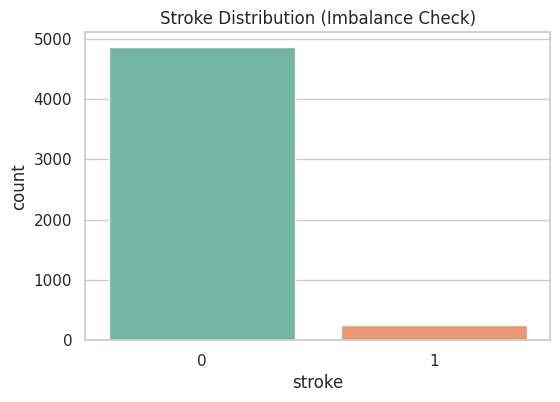

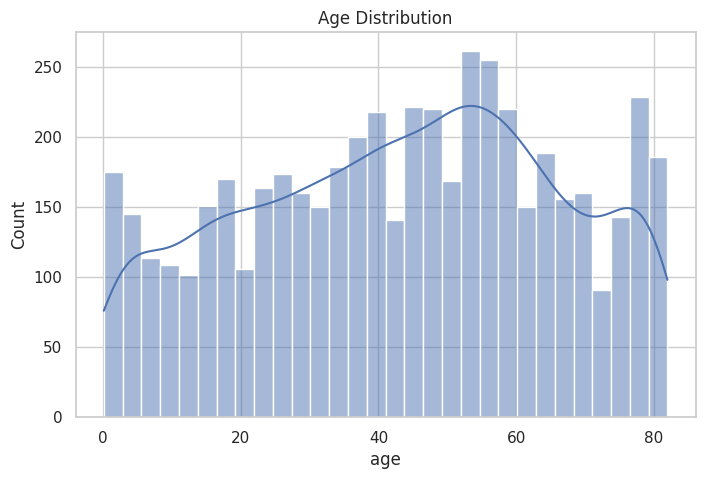

/tmp/ipython-input-203852075.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='Set3')


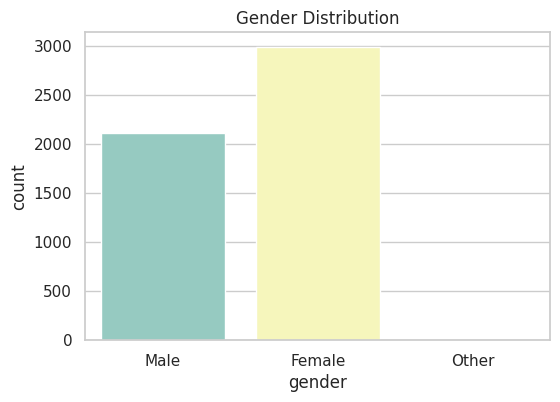

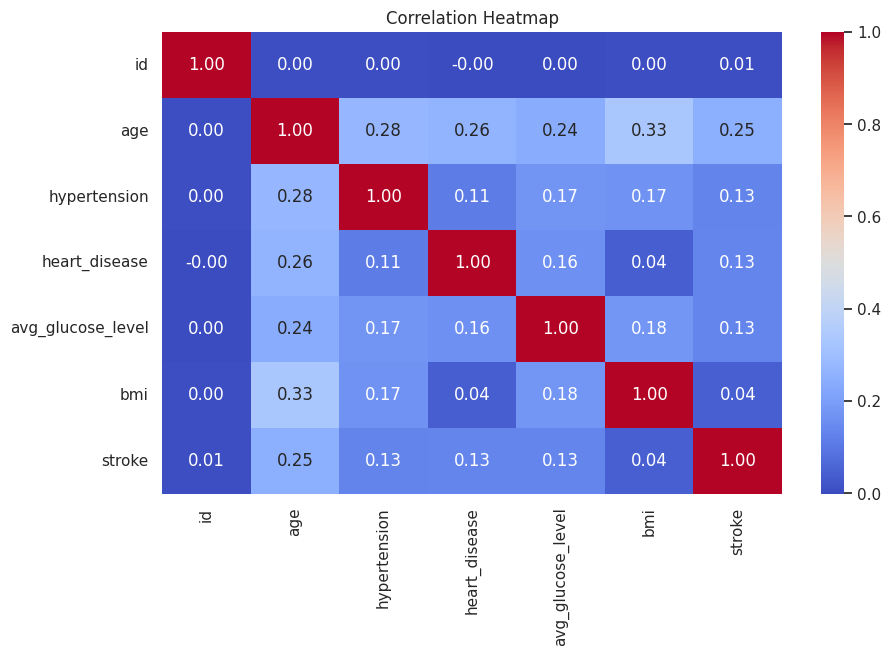

/tmp/ipython-input-203852075.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stroke', y='age', data=df, palette='Set1')


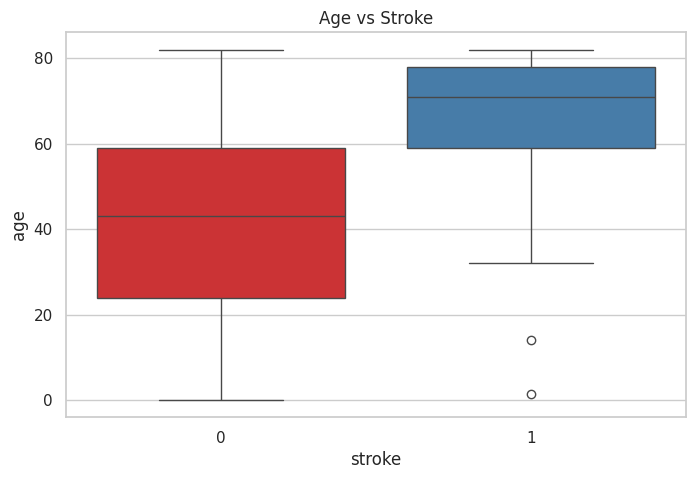

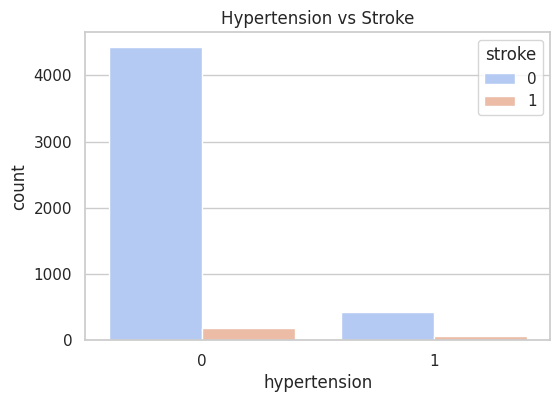

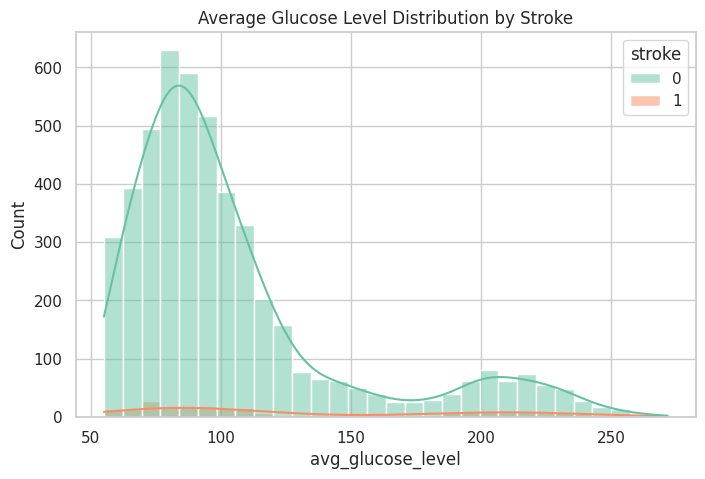

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load dataset
csv_path = '/content/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(csv_path)

# Basic info
print(df.head())
print(df.info())
print(df.describe())

# Set style
sns.set(style="whitegrid")

# 1. Class distribution (stroke vs non-stroke)
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=df, palette='Set2')
plt.title("Stroke Distribution (Imbalance Check)")
plt.show()

# 2. Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age', bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# 3. Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df, palette='Set3')
plt.title("Gender Distribution")
plt.show()

# 4. Heatmap for correlations
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 5. Average age by stroke occurrence
plt.figure(figsize=(8, 5))
sns.boxplot(x='stroke', y='age', data=df, palette='Set1')
plt.title("Age vs Stroke")
plt.show()

# 6. Hypertension & Stroke relationship
plt.figure(figsize=(6, 4))
sns.countplot(x='hypertension', hue='stroke', data=df, palette='coolwarm')
plt.title("Hypertension vs Stroke")
plt.show()

# 7. Glucose Level distribution by stroke
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='avg_glucose_level', hue='stroke', bins=30, kde=True, palette='Set2')
plt.title("Average Glucose Level Distribution by Stroke")
plt.show()